In [ ]:
## Without Augmentation and selected useful features only
## Removed the early stopping to see how far can it result in the increase in accuracy
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torch.utils.data import WeightedRandomSampler
from torch.optim.lr_scheduler import OneCycleLR


DATA_CSV = "features_dataset.csv"
RANDOM_SEED = 42
N_SPLITS = 5
BATCH_SIZE = 64
EPOCHS = 250
LR = 1e-1
WEIGHT_DECAY = 1e-5
PATIENCE = 8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"



def seed_all(seed=RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if DEVICE.startswith("cuda"):
        torch.cuda.manual_seed_all(seed)
seed_all()

df = pd.read_csv(DATA_CSV)
print("Raw shape:", df.shape)

# Drop unecessarily columns
drop_cols = []
for c in ["filename", "actor_ID", "num_frames", "duration"]:
    if c in df.columns:
        drop_cols.append(c)

# Keep metadata columns optionally (gender) - encode gender if present
metadata_cols = []
if "gender" in df.columns:
    metadata_cols.append("gender")

label_col = "emotion"
if label_col not in df.columns:
    raise RuntimeError(f"Label column '{label_col}' not found in CSV")


numeric_cols = ['Neck_speed_max',
 'Spine2_speed_std',
 'Spine1_range',
 'RightUpLeg_speed_max',
 'LeftLeg_speed_max',
 'LeftLeg_speed_std',
 'Spine3_acc_mean',
 'LeftUpLeg_speed_max',
 'LeftShoulder_speed_max',
 'LeftFoot_speed_max',
 'Spine3_speed_mean',
 'RightUpLeg_speed_std',
 'RightShoulder_speed_max',
 'RightLeg_speed_max',
 'Spine_speed_max',
 'Neck_speed_std',
 'Spine1_acc_mean',
 'Spine_range',
 'RightUpLeg_range',
 'Spine2_speed_mean',
 'LeftFoot_speed_std',
 'LeftUpLeg_speed_std',
 'LeftArm_speed_max',
 'Spine_speed_std',
 'LeftUpLeg_range',
 'RightLeg_range',
 'overall_speed_max',
 'LeftHand_speed_max',
 'RightFoot_speed_std',
 'RightLeg_speed_std',
 'RightFoot_speed_max',
 'LeftArm_range',
 'LeftForeArm_speed_std',
 'Neck_acc_mean',
 'Spine_acc_mean',
 'LeftFoot_speed_mean',
 'LeftForeArm_speed_max',
 'LeftHand_speed_std',
 'RightFoot_acc_mean',
 'RightFoot_speed_mean',
 'overall_speed_std',
 'RightArm_speed_max',
 'LeftFoot_range',
 'RightForeArm_speed_max',
 'LeftShoulder_range',
 'LeftShoulder_speed_std',
 'LeftForeArm_range',
 'RightShoulder_speed_std',
 'RightLeg_acc_mean',
 'RightLeg_speed_mean',
 'LeftFoot_acc_mean',
 'LeftArm_speed_std',
 'LeftArm_acc_mean',
 'Spine_speed_mean',
 'RightFoot_range',
 'LeftHand_range',
 'Spine1_speed_mean',
 'LeftLeg_acc_mean',
 'RightShoulder_range',
 'RightShoulder_acc_mean',
 'LeftUpLeg_acc_mean',
 'LeftLeg_speed_mean',
 'RightHand_speed_max',
 'Head_speed_max',
 'LeftArm_speed_mean',
 'RightForeArm_range',
 'LeftUpLeg_speed_mean',
 'LeftHand_acc_mean',
 'RightHand_range',
 'RightArm_speed_std',
 'RightArm_range',
 'LeftForeArm_speed_mean',
 'RightUpLeg_acc_mean',
 'RightForeArm_speed_std',
 'RightShoulder_speed_mean',
 'LeftHand_speed_mean',
 'Head_speed_std',
 'Head_speed_mean',
 'LeftForeArm_acc_mean',
 'RightHand_speed_std',
 'LeftShoulder_acc_mean',
 'RightUpLeg_speed_mean',
 'Head_acc_mean',
 'RightArm_speed_mean',
 'overall_speed_mean',
 'Hips_speed_max',
 'movement_intensity',
 'Hips_range',
 'Neck_speed_mean',
 'RightArm_acc_mean',
 'RightForeArm_acc_mean',
 'LeftShoulder_speed_mean',
 'RightHand_acc_mean',
 'Hips_speed_mean',
 'Neck_range',
 'RightForeArm_speed_mean',
 'Hips_speed_std',
 'RightHand_speed_mean',
 'Head_range',
 'Hips_acc_mean']


numeric_cols = [c for c in numeric_cols if pd.api.types.is_numeric_dtype(df[c])]

print("Using numeric features:", len(numeric_cols))
X_num = df[numeric_cols].fillna(0).values


X_meta = None
if "gender" in metadata_cols:
    # simple map Female->0 Male->1 else nan->-1
    gmap = {"Female": 0, "Male": 1}
    g = df["gender"].map(gmap).fillna(-1).astype(np.float32).values.reshape(-1,1)
    X_meta = g


if X_meta is not None:
    X = np.hstack([X_num, X_meta])
else:
    X = X_num

le = LabelEncoder()
y = le.fit_transform(df[label_col].astype(str).values)
class_names = le.classes_
print("Classes:", list(class_names))
print("Counts:", dict(pd.Series(y).map(lambda v: class_names[v]).value_counts()))


class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class MLP_small(nn.Module):
    def __init__(self, in_dim, n_classes, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(256,128),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(128,64),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(64, n_classes)
        )
    def forward(self, x):
        return self.net(x)


def mixup_data(x, y, alpha=0.2):
    if alpha <= 0:
        return x, y, None, None, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size, device=x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, index, lam

def mixup_criterion(criterion, preds, y_a, y_b, lam):
    return lam * criterion(preds, y_a) + (1 - lam) * criterion(preds, y_b)

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
    def forward(self, inputs, targets):
        ce = nn.functional.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce)
        loss = ((1-pt)**self.gamma * ce).mean()
        return loss

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device); yb = yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

def eval_model(model, loader, device):
    model.eval()
    preds_all = []
    ys_all = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb)
            preds_all.append(out.softmax(dim=1).cpu().numpy())
            ys_all.append(yb.numpy())
    preds_all = np.vstack(preds_all)
    ys_all = np.concatenate(ys_all)
    preds_labels = preds_all.argmax(axis=1)
    acc = (preds_labels == ys_all).mean()
    return acc, preds_labels, ys_all, preds_all

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
fold_results = []
all_preds = []
all_trues = []
best_models = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n=== Fold {fold+1}/{N_SPLITS} ===")
    X_tr, X_val = X[tr_idx], X[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]

    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    X_tr = pt.fit_transform(X_tr)
    X_val = pt.transform(X_val)

    train_ds = TabularDataset(X_tr, y_tr)
    val_ds = TabularDataset(X_val, y_val)

    vals, counts = np.unique(y_tr, return_counts=True)
    inv_freq = 1.0 / (counts + 1e-12)
    weight_vec = np.zeros(len(class_names), dtype=np.float32)
    for cls_i, inv in zip(vals, inv_freq):
        weight_vec[cls_i] = inv
    weight_tensor = torch.tensor(weight_vec, dtype=torch.float32).to(DEVICE)

    sample_weights = np.array([weight_vec[yv] for yv in y_tr], dtype=np.float32)
    sample_weights = sample_weights / sample_weights.sum()
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
    tr_loader = DataLoader(train_ds, batch_size=128, sampler=sampler, num_workers=0)

    val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=0)

    model = MLP_small(in_dim=X_tr.shape[1], n_classes=len(class_names), dropout=0.2).to(DEVICE)

    criterion = nn.CrossEntropyLoss(weight=weight_tensor, label_smoothing=0.08)

    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

    steps_per_epoch = max(1, len(tr_loader))
    scheduler = OneCycleLR(optimizer, max_lr=1e-2, steps_per_epoch=steps_per_epoch, epochs=EPOCHS)

    best_val = 0.0
    epochs_no_improve = 0
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0.0
        for xb, yb in tr_loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)

            xb_m, ya, yb_mix, _, lam = mixup_data(xb, yb, alpha=0.2)
            preds = model(xb_m)

            if lam is None:
                loss = criterion(preds, yb)
            else:
                loss = mixup_criterion(criterion, preds, ya, yb_mix, lam)

            optimizer.zero_grad(); loss.backward(); optimizer.step()
            total_loss += loss.item() * xb.size(0)
            scheduler.step()

        avg_loss = total_loss / len(tr_loader.dataset)
        val_acc, val_preds, val_trues, _ = eval_model(model, val_loader, DEVICE)
        print(f"Epoch {epoch+1}: train_loss={avg_loss:.4f} val_acc={val_acc:.4f} best={best_val:.4f}")

        if val_acc > best_val + 1e-5:
            best_val = val_acc
            epochs_no_improve = 0
            # torch.save(model.state_dict(), f"best_mlp_fold{fold}.pth")

Raw shape: (1401, 305)
Using numeric features: 100
Classes: ['Angry', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprise']
Counts: {'Fearful': np.int64(216), 'Happy': np.int64(216), 'Surprise': np.int64(212), 'Disgust': np.int64(210), 'Sad': np.int64(202), 'Angry': np.int64(200), 'Neutral': np.int64(145)}

=== Fold 1/5 ===
Epoch 1: train_loss=1.9358 val_acc=0.2491 best=0.0000
Epoch 2: train_loss=1.8737 val_acc=0.2633 best=0.2491
Epoch 3: train_loss=1.8055 val_acc=0.2740 best=0.2633
Epoch 4: train_loss=1.7659 val_acc=0.2705 best=0.2740
Epoch 5: train_loss=1.7321 val_acc=0.3203 best=0.2740
Epoch 6: train_loss=1.7044 val_acc=0.3167 best=0.3203
Epoch 7: train_loss=1.7050 val_acc=0.3488 best=0.3203
Epoch 8: train_loss=1.6175 val_acc=0.3452 best=0.3488
Epoch 9: train_loss=1.6026 val_acc=0.3701 best=0.3488
Epoch 10: train_loss=1.5497 val_acc=0.4021 best=0.3701
Epoch 11: train_loss=1.6120 val_acc=0.4128 best=0.4021
Epoch 12: train_loss=1.5464 val_acc=0.4235 best=0.4128
Epoch 13: train_

In [ ]:
### Applying Augmentation to the minority classes
### Not a significant change after applying augmentation so removing the early stopping in order to increase the accuracy and changing the epochs to 200
### Changing the Hyperparameters based upon the optuna hyperparameter tuning
## {'lr': 0.006308297609579304, 'dropout': 0.40732238402293397, 'hidden_dim': 512, 'weight_decay': 2.217794034655606e-05, 'label_smoothing': 0.15558780521663396}


import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Config
DATA_CSV = "features dataset.csv"
RANDOM_SEED = 42
N_SPLITS = 5
BATCH_SIZE = 128
EPOCHS = 500
PATIENCE = 25
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def seed_all(seed=RANDOM_SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if DEVICE.startswith("cuda"):
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
seed_all()

# ============ FEATURE ENGINEERING ============
def add_derived_features(df):

    # Symmetry features (asymmetric movements may indicate certain emotions)
    df['arm_asymmetry'] = abs(df['RightArm_speed_max'] - df['LeftArm_speed_max'])
    df['leg_asymmetry'] = abs(df['RightLeg_speed_max'] - df['LeftLeg_speed_max'])
    df['shoulder_asymmetry'] = abs(df['RightShoulder_speed_max'] - df['LeftShoulder_speed_max'])

    # Body region ratios
    upper_speed = df['RightArm_speed_max'] + df['LeftArm_speed_max'] + df['Head_speed_max']
    lower_speed = df['RightLeg_speed_max'] + df['LeftLeg_speed_max'] + 1e-6
    df['upper_lower_ratio'] = upper_speed / lower_speed

    # Movement coordination (std across limbs)
    limb_cols = ['RightArm_speed_std', 'LeftArm_speed_std',
                 'RightLeg_speed_std', 'LeftLeg_speed_std']
    df['limb_coordination'] = df[limb_cols].std(axis=1)

    # Core body movement
    core_cols = ['Spine_speed_max', 'Spine1_speed_max', 'Spine2_speed_max']
    df['core_movement_intensity'] = df[core_cols].mean(axis=1)

    # Extremity movement variance
    extremity_cols = ['RightHand_speed_max', 'LeftHand_speed_max',
                      'RightFoot_speed_max', 'LeftFoot_speed_max']
    df['extremity_variation'] = df[extremity_cols].std(axis=1)

    # Upper body expressiveness
    expressive_cols = ['Head_speed_max', 'Neck_speed_max',
                       'RightArm_speed_max', 'LeftArm_speed_max']
    df['upper_expressiveness'] = df[expressive_cols].mean(axis=1)

    return df


df = pd.read_csv(DATA_CSV)
print("Raw shape:", df.shape)

df = add_derived_features(df)


drop_cols = ["filename", "actor_ID", "num_frames", "duration"]
drop_cols = [c for c in drop_cols if c in df.columns]

label_col = "emotion"
metadata_cols = ["gender"] if "gender" in df.columns else []

numeric_cols = [c for c in df.columns
                if c not in drop_cols + [label_col] + metadata_cols
                and pd.api.types.is_numeric_dtype(df[c])]

print(f"Using {len(numeric_cols)} features (including engineered)")

X_num = df[numeric_cols].fillna(0).values


X_meta = None
if "gender" in metadata_cols:
    gmap = {"Female": 0, "Male": 1}
    g = df["gender"].map(gmap).fillna(-1).astype(np.float32).values.reshape(-1,1)
    X_meta = g

X = np.hstack([X_num, X_meta]) if X_meta is not None else X_num


le = LabelEncoder()
y = le.fit_transform(df[label_col].astype(str).values)
class_names = le.classes_
print("Classes:", list(class_names))
print("Distribution:", dict(pd.Series(y).value_counts()))

def augment_emotion_data(X, y, emotion_id, n_augment=100):

    mask = y == emotion_id
    X_emotion = X[mask]

    augmented = []
    for _ in range(n_augment):
        idx1, idx2 = np.random.choice(len(X_emotion), 2, replace=False)

        alpha = np.random.beta(2, 2)  # Center-weighted
        new_sample = alpha * X_emotion[idx1] + (1-alpha) * X_emotion[idx2]

        noise = np.random.normal(0, 0.01, new_sample.shape)
        augmented.append(new_sample + noise)

    return np.array(augmented)


for emotion_id in range(len(class_names)):
    if np.sum(y == emotion_id) < 180:
        aug_X = augment_emotion_data(X, y, emotion_id, n_augment=50)
        aug_y = np.full(50, emotion_id)
        X_tr = np.vstack([X, aug_X])
        y_tr = np.concatenate([y, aug_y])

X = X_tr
y = y_tr
class_names = le.classes_
print("Classes After Augmentation:", list(class_names))
print("Distribution after Augmentation:", dict(pd.Series(y).value_counts()))


class TabularDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.augment = augment

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.augment:
            noise = np.random.normal(0, 0.02, x.shape).astype(np.float32)
            x = x + noise
        return x, self.y[idx]


class ImprovedMLP(nn.Module):
    def __init__(self, in_dim, n_classes, dropout=0.3):
      super().__init__()
      self.net = nn.Sequential(
          nn.Linear(in_dim, 512),
          nn.BatchNorm1d(512),
          nn.ReLU(),
          nn.Dropout(dropout),

          nn.Linear(512, 256),
          nn.BatchNorm1d(256),
          nn.ReLU(),
          nn.Dropout(dropout),

          nn.Linear(256, 128),
          nn.BatchNorm1d(128),
          nn.ReLU(),
          nn.Dropout(dropout),

          nn.Linear(128, 64),
          nn.BatchNorm1d(64),
          nn.ReLU(),
          nn.Dropout(dropout),

          nn.Linear(64, n_classes)
      )

    def forward(self, x):
        return self.net(x)

def mixup_data(x, y, alpha=0.2):
    if alpha <= 0:
        return x, y, None, None, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size, device=x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, index, lam

def mixup_criterion(criterion, preds, y_a, y_b, lam):
    return lam * criterion(preds, y_a) + (1 - lam) * criterion(preds, y_b)

def eval_model(model, loader, device):
    model.eval()
    all_preds, all_trues, all_probs = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu().numpy())
            all_trues.append(yb.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_trues = np.concatenate(all_trues)
    all_probs = np.concatenate(all_probs)
    acc = accuracy_score(all_trues, all_preds)
    return acc, all_preds, all_trues, all_probs

Raw shape: (1401, 305)
Using 307 features (including engineered)
Classes: ['Angry', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprise']
Distribution: {2: np.int64(216), 3: np.int64(216), 6: np.int64(212), 1: np.int64(210), 5: np.int64(202), 0: np.int64(200), 4: np.int64(145)}
Classes After Augmentation: ['Angry', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprise']
Distribution after Augmentation: {2: np.int64(216), 3: np.int64(216), 6: np.int64(212), 1: np.int64(210), 5: np.int64(202), 0: np.int64(200), 4: np.int64(195)}



FOLD 1/5
Epoch 1/200: loss=1.8864 val_acc=0.2852 best=0.0000
Epoch 11/200: loss=1.6362 val_acc=0.4674 best=0.4777
Epoch 21/200: loss=1.6093 val_acc=0.4227 best=0.5120
Epoch 31/200: loss=1.6500 val_acc=0.5086 best=0.5120
Epoch 41/200: loss=1.4880 val_acc=0.5430 best=0.5189
Epoch 51/200: loss=1.5393 val_acc=0.5361 best=0.5533
Epoch 61/200: loss=1.4970 val_acc=0.5258 best=0.5533
Epoch 71/200: loss=1.6232 val_acc=0.4983 best=0.5533
Epoch 81/200: loss=1.4473 val_acc=0.5464 best=0.5601
Epoch 91/200: loss=1.5689 val_acc=0.5017 best=0.5601
Epoch 101/200: loss=1.3412 val_acc=0.5292 best=0.5601
Epoch 111/200: loss=1.4411 val_acc=0.5086 best=0.5601
Epoch 121/200: loss=1.4278 val_acc=0.5567 best=0.5636
Epoch 131/200: loss=1.3667 val_acc=0.5498 best=0.5636
Epoch 141/200: loss=1.3314 val_acc=0.5189 best=0.5636
Epoch 151/200: loss=1.3823 val_acc=0.5326 best=0.5636
Epoch 161/200: loss=1.4474 val_acc=0.5326 best=0.5636
Epoch 171/200: loss=1.5420 val_acc=0.4880 best=0.5739
Epoch 181/200: loss=1.4106 va

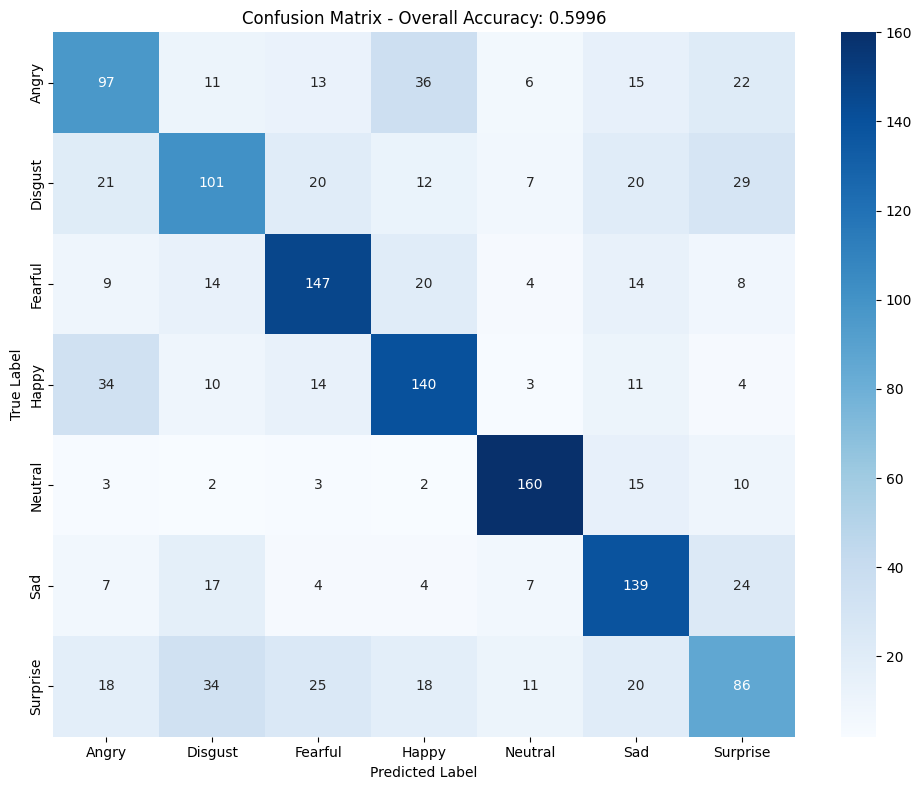


Classification Report:
              precision    recall  f1-score   support

       Angry       0.51      0.48      0.50       200
     Disgust       0.53      0.48      0.51       210
     Fearful       0.65      0.68      0.67       216
       Happy       0.60      0.65      0.62       216
     Neutral       0.81      0.82      0.81       195
         Sad       0.59      0.69      0.64       202
    Surprise       0.47      0.41      0.44       212

    accuracy                           0.60      1451
   macro avg       0.60      0.60      0.60      1451
weighted avg       0.59      0.60      0.60      1451



In [ ]:
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
fold_results = []
all_fold_preds = []
all_fold_trues = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"\n{'='*50}")
    print(f"FOLD {fold+1}/{N_SPLITS}")
    print('='*50)

    X_tr, X_val = X[tr_idx], X[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]


    mi_scores = mutual_info_classif(X_tr, y_tr, random_state=RANDOM_SEED)
    n_select = min(150, len(mi_scores))
    top_features = np.argsort(mi_scores)[-n_select:]

    X_tr = X_tr[:, top_features]
    X_val = X_val[:, top_features]


    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    X_tr = pt.fit_transform(X_tr)
    X_val = pt.transform(X_val)


    train_ds = TabularDataset(X_tr, y_tr, augment=True)
    val_ds = TabularDataset(X_val, y_val, augment=False)


    vals, counts = np.unique(y_tr, return_counts=True)
    inv_freq = 1.0 / (counts + 1e-12)
    weight_vec = np.zeros(len(class_names), dtype=np.float32)
    for cls_i, inv in zip(vals, inv_freq):
        weight_vec[cls_i] = inv

    sample_weights = np.array([weight_vec[yv] for yv in y_tr], dtype=np.float32)
    sample_weights = sample_weights / sample_weights.sum()
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights),
                                  replacement=True)

    tr_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=0)


    model = ImprovedMLP(in_dim=X_tr.shape[1], n_classes=len(class_names), dropout=0.40732238402293397).to(DEVICE)


    weight_tensor = torch.tensor(weight_vec, dtype=torch.float32).to(DEVICE)
    criterion = nn.CrossEntropyLoss(weight=weight_tensor, label_smoothing=0.15558780521663396)


    optimizer = optim.AdamW(model.parameters(), lr=0.006308297609579304, weight_decay=2.217794034655606e-05)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2)


    best_val_acc = 0.0
    epochs_no_improve = 0


    EPOCHS = 200
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0.0

        for xb, yb in tr_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            # Mixup augmentation
            xb_m, ya, yb_mix, _, lam = mixup_data(xb, yb, alpha=0.2)
            preds = model(xb_m)

            if lam is None:
                loss = criterion(preds, yb)
            else:
                loss = mixup_criterion(criterion, preds, ya, yb_mix, lam)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)

        scheduler.step()

        avg_loss = total_loss / len(tr_loader.dataset)
        val_acc, val_preds, val_trues, _ = eval_model(model, val_loader, DEVICE)

        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS}: loss={avg_loss:.4f} val_acc={val_acc:.4f} best={best_val_acc:.4f}")


        if val_acc > best_val_acc + 1e-9:
            best_val_acc = val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), f"best_mlp_fold{fold}.pth")


    model.load_state_dict(torch.load(f"best_mlp_fold{fold}.pth", map_location=DEVICE))
    val_acc, val_preds, val_trues, val_probs = eval_model(model, val_loader, DEVICE)

    print(f"\nFold {fold+1} Best Validation Accuracy: {val_acc:.4f}")
    fold_results.append(val_acc)
    all_fold_preds.append(val_preds)
    all_fold_trues.append(val_trues)

mean_acc = np.mean(fold_results)
std_acc = np.std(fold_results)
print(f"\n{'='*50}")
print(f"CROSS-VALIDATION RESULTS")
print('='*50)
print(f"Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
print(f"Fold Accuracies: {[f'{acc:.4f}' for acc in fold_results]}")


all_preds = np.concatenate(all_fold_preds)
all_trues = np.concatenate(all_fold_trues)
cm = confusion_matrix(all_trues, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title(f"Confusion Matrix - Overall Accuracy: {mean_acc:.4f}")
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

print("\nClassification Report:")
print(classification_report(all_trues, all_preds, target_names=class_names))


In [2]:
### Optuna Hyperparameter Tuning

In [ ]:
import optuna

def objective(trial):
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
  hidden_dim = trial.suggest_categorical('hidden_dim', [256, 512, 768])
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
  label_smoothing = trial.suggest_uniform('label_smoothing', 0.05, 0.2)


  skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)
  fold_results = []
  all_fold_preds = []
  all_fold_trues = []

  for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
      print(f"\n{'='*50}")
      print(f"FOLD {fold+1}/{N_SPLITS}")
      print('='*50)

      X_tr, X_val = X[tr_idx], X[val_idx]
      y_tr, y_val = y[tr_idx], y[val_idx]

      mi_scores = mutual_info_classif(X_tr, y_tr, random_state=RANDOM_SEED)
      n_select = min(150, len(mi_scores))
      top_features = np.argsort(mi_scores)[-n_select:]

      X_tr = X_tr[:, top_features]
      X_val = X_val[:, top_features]


      pt = PowerTransformer(method='yeo-johnson', standardize=True)
      X_tr = pt.fit_transform(X_tr)
      X_val = pt.transform(X_val)


      train_ds = TabularDataset(X_tr, y_tr, augment=True)
      val_ds = TabularDataset(X_val, y_val, augment=False)


      vals, counts = np.unique(y_tr, return_counts=True)
      inv_freq = 1.0 / (counts + 1e-12)
      weight_vec = np.zeros(len(class_names), dtype=np.float32)
      for cls_i, inv in zip(vals, inv_freq):
          weight_vec[cls_i] = inv


      sample_weights = np.array([weight_vec[yv] for yv in y_tr], dtype=np.float32)
      sample_weights = sample_weights / sample_weights.sum()
      sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights),
                                    replacement=True)

      tr_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0)
      val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=0)


      model = ImprovedMLP(in_dim=X_tr.shape[1], n_classes=len(class_names), dropout=0.3).to(DEVICE)


      weight_tensor = torch.tensor(weight_vec, dtype=torch.float32).to(DEVICE)
      criterion = nn.CrossEntropyLoss(weight=weight_tensor, label_smoothing=0.1)


      optimizer = optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-4)
      scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=20, T_mult=2)


      best_val_acc = 0.0
      epochs_no_improve = 0

      for epoch in range(EPOCHS):
          model.train()
          total_loss = 0.0

          for xb, yb in tr_loader:
              xb, yb = xb.to(DEVICE), yb.to(DEVICE)

              xb_m, ya, yb_mix, _, lam = mixup_data(xb, yb, alpha=0.2)
              preds = model(xb_m)

              if lam is None:
                  loss = criterion(preds, yb)
              else:
                  loss = mixup_criterion(criterion, preds, ya, yb_mix, lam)

              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
              total_loss += loss.item() * xb.size(0)

          scheduler.step()

          avg_loss = total_loss / len(tr_loader.dataset)
          val_acc, val_preds, val_trues, _ = eval_model(model, val_loader, DEVICE)

  return val_acc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print("Best hyperparameters:", study.best_params)

[I 2025-11-23 20:28:52,528] A new study created in memory with name: no-name-ef683e1f-03af-415c-a9bc-d6ac9c6a74a1
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
/tmp/i


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 20:34:19,816] Trial 0 finished with value: 0.5392857142857143 and parameters: {'lr': 0.0001093583852398236, 'dropout': 0.385159699102071, 'hidden_dim': 768, 'weight_decay': 2.2432619820019648e-05, 'label_smoothing': 0.14958264459838616}. Best is trial 0 with value: 0.5392857142857143.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 20:39:32,813] Trial 1 finished with value: 0.5535714285714286 and parameters: {'lr': 0.0005232815691718069, 'dropout': 0.4202305368045831, 'hidden_dim': 512, 'weight_decay': 8.39422649077822e-06, 'label_smoothing': 0.18477074444245822}. Best is trial 1 with value: 0.5535714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 20:44:46,649] Trial 2 finished with value: 0.5428571428571428 and parameters: {'lr': 0.004265753268941966, 'dropout': 0.37340945571891204, 'hidden_dim': 512, 'weight_decay': 2.064626705221874e-05, 'label_smoothing': 0.13851751432712958}. Best is trial 1 with value: 0.5535714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 20:49:58,888] Trial 3 finished with value: 0.5392857142857143 and parameters: {'lr': 0.00023062024232513577, 'dropout': 0.42546276832288005, 'hidden_dim': 512, 'weight_decay': 1.042295176513955e-06, 'label_smoothing': 0.09713258738919145}. Best is trial 1 with value: 0.5535714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 20:55:14,910] Trial 4 finished with value: 0.5392857142857143 and parameters: {'lr': 0.0012867162444341058, 'dropout': 0.47207398879196477, 'hidden_dim': 256, 'weight_decay': 1.3889805078079793e-05, 'label_smoothing': 0.0820216521895075}. Best is trial 1 with value: 0.5535714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed 


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 21:00:32,328] Trial 5 finished with value: 0.5464285714285714 and parameters: {'lr': 0.0006420663291381136, 'dropout': 0.30741452566371175, 'hidden_dim': 256, 'weight_decay': 3.7079045143568945e-05, 'label_smoothing': 0.05863376386291727}. Best is trial 1 with value: 0.5535714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 21:05:44,884] Trial 6 finished with value: 0.5357142857142857 and parameters: {'lr': 0.0018892350798535315, 'dropout': 0.3112228671788869, 'hidden_dim': 768, 'weight_decay': 3.332174453907458e-06, 'label_smoothing': 0.08442981697813447}. Best is trial 1 with value: 0.5535714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 21:10:55,836] Trial 7 finished with value: 0.5607142857142857 and parameters: {'lr': 0.0006577990694131069, 'dropout': 0.2945145346451839, 'hidden_dim': 768, 'weight_decay': 0.00010393199742017537, 'label_smoothing': 0.11754544840807471}. Best is trial 7 with value: 0.5607142857142857.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed 


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 21:16:09,328] Trial 8 finished with value: 0.5642857142857143 and parameters: {'lr': 0.00011418267914050485, 'dropout': 0.4939489590741553, 'hidden_dim': 256, 'weight_decay': 1.26711415909089e-05, 'label_smoothing': 0.17343859897233532}. Best is trial 8 with value: 0.5642857142857143.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 21:21:23,115] Trial 9 finished with value: 0.5607142857142857 and parameters: {'lr': 0.0008451870660211066, 'dropout': 0.4711368185677354, 'hidden_dim': 256, 'weight_decay': 1.600003509747021e-06, 'label_smoothing': 0.11129252164304326}. Best is trial 8 with value: 0.5642857142857143.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 21:26:33,059] Trial 10 finished with value: 0.55 and parameters: {'lr': 0.00010054680814428207, 'dropout': 0.23380095206832419, 'hidden_dim': 256, 'weight_decay': 0.000992763132540997, 'label_smoothing': 0.1894365640941635}. Best is trial 8 with value: 0.5642857142857143.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 21:31:44,299] Trial 11 finished with value: 0.5535714285714286 and parameters: {'lr': 0.008945891282467736, 'dropout': 0.23449842384756675, 'hidden_dim': 768, 'weight_decay': 0.00015430637345283148, 'label_smoothing': 0.16048634936838777}. Best is trial 8 with value: 0.5642857142857143.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 21:36:54,547] Trial 12 finished with value: 0.5142857142857142 and parameters: {'lr': 0.00027865182820454345, 'dropout': 0.3203914569797567, 'hidden_dim': 768, 'weight_decay': 0.0001333417520889863, 'label_smoothing': 0.12494964597556744}. Best is trial 8 with value: 0.5642857142857143.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 21:42:05,146] Trial 13 finished with value: 0.5571428571428572 and parameters: {'lr': 0.00028753903922410136, 'dropout': 0.27649881236356155, 'hidden_dim': 256, 'weight_decay': 0.0001197958187733221, 'label_smoothing': 0.1710580299591504}. Best is trial 8 with value: 0.5642857142857143.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 21:47:14,956] Trial 14 finished with value: 0.5571428571428572 and parameters: {'lr': 0.0020825263543983695, 'dropout': 0.20358042925985909, 'hidden_dim': 768, 'weight_decay': 0.0005247270575477257, 'label_smoothing': 0.12857532487131104}. Best is trial 8 with value: 0.5642857142857143.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 21:52:25,124] Trial 15 finished with value: 0.5535714285714286 and parameters: {'lr': 0.0001837594817807152, 'dropout': 0.34985869348208165, 'hidden_dim': 256, 'weight_decay': 6.144307478991405e-05, 'label_smoothing': 0.1986766471315913}. Best is trial 8 with value: 0.5642857142857143.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed 


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 21:57:35,532] Trial 16 finished with value: 0.5607142857142857 and parameters: {'lr': 0.0005464383051655719, 'dropout': 0.27175000603576605, 'hidden_dim': 768, 'weight_decay': 5.322538755813762e-06, 'label_smoothing': 0.11005947402939151}. Best is trial 8 with value: 0.5642857142857143.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 22:02:47,615] Trial 17 finished with value: 0.5678571428571428 and parameters: {'lr': 0.004100951289077328, 'dropout': 0.41492096262481415, 'hidden_dim': 768, 'weight_decay': 5.411401243128219e-05, 'label_smoothing': 0.16752225784564118}. Best is trial 17 with value: 0.5678571428571428.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 22:07:57,159] Trial 18 finished with value: 0.5321428571428571 and parameters: {'lr': 0.00447614767170728, 'dropout': 0.4980008760591982, 'hidden_dim': 256, 'weight_decay': 0.00026948845221612166, 'label_smoothing': 0.16685482792154102}. Best is trial 17 with value: 0.5678571428571428.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed 


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 22:13:06,654] Trial 19 finished with value: 0.5464285714285714 and parameters: {'lr': 0.009946086467946424, 'dropout': 0.4311840488178034, 'hidden_dim': 512, 'weight_decay': 4.6454306768451244e-05, 'label_smoothing': 0.14701559746602386}. Best is trial 17 with value: 0.5678571428571428.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 22:18:14,421] Trial 20 finished with value: 0.525 and parameters: {'lr': 0.004328461312052517, 'dropout': 0.45446255836347393, 'hidden_dim': 768, 'weight_decay': 1.0999216368360756e-05, 'label_smoothing': 0.17778469791312934}. Best is trial 17 with value: 0.5678571428571428.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. 


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 22:23:22,919] Trial 21 finished with value: 0.5571428571428572 and parameters: {'lr': 0.0021487254425659563, 'dropout': 0.3998859390342003, 'hidden_dim': 768, 'weight_decay': 8.137466276562765e-05, 'label_smoothing': 0.15647053877472133}. Best is trial 17 with value: 0.5678571428571428.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 22:28:32,481] Trial 22 finished with value: 0.5392857142857143 and parameters: {'lr': 0.00039319326575123267, 'dropout': 0.35932956476811156, 'hidden_dim': 768, 'weight_decay': 0.0003108947018379466, 'label_smoothing': 0.13123831595410704}. Best is trial 17 with value: 0.5678571428571428.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remov


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 22:33:42,863] Trial 23 finished with value: 0.5428571428571428 and parameters: {'lr': 0.0012142210578506268, 'dropout': 0.4946956337891349, 'hidden_dim': 768, 'weight_decay': 2.3019581144503828e-05, 'label_smoothing': 0.10781997143726577}. Best is trial 17 with value: 0.5678571428571428.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remove


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 22:38:54,586] Trial 24 finished with value: 0.525 and parameters: {'lr': 0.0028348009268728156, 'dropout': 0.4448691825429091, 'hidden_dim': 768, 'weight_decay': 8.534736884894299e-05, 'label_smoothing': 0.197599695261229}. Best is trial 17 with value: 0.5678571428571428.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 22:44:08,098] Trial 25 finished with value: 0.5428571428571428 and parameters: {'lr': 0.00017184004307664645, 'dropout': 0.33317359548790304, 'hidden_dim': 256, 'weight_decay': 3.952832688863354e-05, 'label_smoothing': 0.18019638081393077}. Best is trial 17 with value: 0.5678571428571428.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remov


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 22:49:19,752] Trial 26 finished with value: 0.5535714285714286 and parameters: {'lr': 0.00038942831977589927, 'dropout': 0.2862879918880194, 'hidden_dim': 768, 'weight_decay': 5.6471851032164395e-06, 'label_smoothing': 0.14112983445354724}. Best is trial 17 with value: 0.5678571428571428.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remov


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 22:54:32,506] Trial 27 finished with value: 0.5464285714285714 and parameters: {'lr': 0.00760515603217199, 'dropout': 0.3938006902059144, 'hidden_dim': 768, 'weight_decay': 0.0001928066171752809, 'label_smoothing': 0.12152584513446028}. Best is trial 17 with value: 0.5678571428571428.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 22:59:44,910] Trial 28 finished with value: 0.5714285714285714 and parameters: {'lr': 0.000825859273529576, 'dropout': 0.4050472873430277, 'hidden_dim': 512, 'weight_decay': 5.878094091461419e-05, 'label_smoothing': 0.16927667685513773}. Best is trial 28 with value: 0.5714285714285714.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed 


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 23:04:57,477] Trial 29 finished with value: 0.5678571428571428 and parameters: {'lr': 0.00015973029628847804, 'dropout': 0.4052254736491052, 'hidden_dim': 512, 'weight_decay': 2.2233411960036785e-05, 'label_smoothing': 0.15488740921649535}. Best is trial 28 with value: 0.5714285714285714.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remov


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 23:10:12,555] Trial 30 finished with value: 0.5785714285714286 and parameters: {'lr': 0.006308297609579304, 'dropout': 0.40732238402293397, 'hidden_dim': 512, 'weight_decay': 2.217794034655606e-05, 'label_smoothing': 0.15558780521663396}. Best is trial 30 with value: 0.5785714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 23:15:24,553] Trial 31 finished with value: 0.5428571428571428 and parameters: {'lr': 0.005934237295007318, 'dropout': 0.40638507299637316, 'hidden_dim': 512, 'weight_decay': 2.2923658294052377e-05, 'label_smoothing': 0.15142776449200102}. Best is trial 30 with value: 0.5785714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remove


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 23:20:37,197] Trial 32 finished with value: 0.5214285714285715 and parameters: {'lr': 0.00311201567494257, 'dropout': 0.3761068406771266, 'hidden_dim': 512, 'weight_decay': 2.4390688928198386e-05, 'label_smoothing': 0.1617599242230668}. Best is trial 30 with value: 0.5785714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 23:25:46,454] Trial 33 finished with value: 0.5178571428571429 and parameters: {'lr': 0.005775077942042546, 'dropout': 0.41137232187394845, 'hidden_dim': 512, 'weight_decay': 5.558768382050031e-05, 'label_smoothing': 0.14095928899605922}. Best is trial 30 with value: 0.5785714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 23:30:57,379] Trial 34 finished with value: 0.55 and parameters: {'lr': 0.0015402283017336641, 'dropout': 0.3837694753794969, 'hidden_dim': 512, 'weight_decay': 3.108919390881099e-05, 'label_smoothing': 0.15445864632884324}. Best is trial 30 with value: 0.5785714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. Se


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 23:36:08,818] Trial 35 finished with value: 0.5535714285714286 and parameters: {'lr': 0.0009445287750632312, 'dropout': 0.434186794893624, 'hidden_dim': 512, 'weight_decay': 1.61026068731456e-05, 'label_smoothing': 0.18924081701789244}. Best is trial 30 with value: 0.5785714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 23:41:17,894] Trial 36 finished with value: 0.5642857142857143 and parameters: {'lr': 0.003208811039779612, 'dropout': 0.36429006911414014, 'hidden_dim': 512, 'weight_decay': 8.19662988400168e-06, 'label_smoothing': 0.1668108165216953}. Best is trial 30 with value: 0.5785714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 23:46:28,937] Trial 37 finished with value: 0.5392857142857143 and parameters: {'lr': 0.006718018310198021, 'dropout': 0.41667629949003854, 'hidden_dim': 512, 'weight_decay': 6.57812012991821e-05, 'label_smoothing': 0.14731115238911507}. Best is trial 30 with value: 0.5785714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed 


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 23:51:40,575] Trial 38 finished with value: 0.55 and parameters: {'lr': 0.0025965537631062385, 'dropout': 0.3455352823874626, 'hidden_dim': 512, 'weight_decay': 3.6962057678307886e-05, 'label_smoothing': 0.18115577301782776}. Best is trial 30 with value: 0.5785714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. S


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-23 23:56:50,862] Trial 39 finished with value: 0.5607142857142857 and parameters: {'lr': 0.00013873813571610048, 'dropout': 0.4576728573032062, 'hidden_dim': 512, 'weight_decay': 1.5370555297454e-05, 'label_smoothing': 0.1330364056375588}. Best is trial 30 with value: 0.5785714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-24 00:01:58,459] Trial 40 finished with value: 0.5642857142857143 and parameters: {'lr': 0.003814907934352694, 'dropout': 0.38502835138116, 'hidden_dim': 512, 'weight_decay': 8.036769663694547e-06, 'label_smoothing': 0.16304579753615975}. Best is trial 30 with value: 0.5785714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-24 00:07:05,774] Trial 41 finished with value: 0.55 and parameters: {'lr': 0.00013384101918935642, 'dropout': 0.4720265713938949, 'hidden_dim': 512, 'weight_decay': 2.844525163334046e-05, 'label_smoothing': 0.17408902074348687}. Best is trial 30 with value: 0.5785714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. S


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-24 00:12:14,349] Trial 42 finished with value: 0.55 and parameters: {'lr': 0.00011487437354736943, 'dropout': 0.4253099443539326, 'hidden_dim': 512, 'weight_decay': 1.0738779500724513e-05, 'label_smoothing': 0.18754157283907566}. Best is trial 30 with value: 0.5785714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. 


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-24 00:17:24,580] Trial 43 finished with value: 0.5428571428571428 and parameters: {'lr': 0.00020451979189629126, 'dropout': 0.3957453868523761, 'hidden_dim': 256, 'weight_decay': 1.9548078307634387e-05, 'label_smoothing': 0.05117718680951194}. Best is trial 30 with value: 0.5785714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remov


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-24 00:22:36,436] Trial 44 finished with value: 0.5607142857142857 and parameters: {'lr': 0.00027489995548363486, 'dropout': 0.44383672955375264, 'hidden_dim': 512, 'weight_decay': 2.602503143527542e-06, 'label_smoothing': 0.17648951124357465}. Best is trial 30 with value: 0.5785714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remov


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-24 00:27:48,316] Trial 45 finished with value: 0.5607142857142857 and parameters: {'lr': 0.0007005267591042003, 'dropout': 0.3682389612740938, 'hidden_dim': 256, 'weight_decay': 5.464493627007753e-06, 'label_smoothing': 0.16928612927046005}. Best is trial 30 with value: 0.5785714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-24 00:33:00,969] Trial 46 finished with value: 0.5785714285714286 and parameters: {'lr': 0.00041691120365531294, 'dropout': 0.47620238140017, 'hidden_dim': 512, 'weight_decay': 1.2534012839834714e-05, 'label_smoothing': 0.15537298895937734}. Best is trial 30 with value: 0.5785714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-24 00:38:13,818] Trial 47 finished with value: 0.5464285714285714 and parameters: {'lr': 0.00047702569233662917, 'dropout': 0.4819598896333599, 'hidden_dim': 512, 'weight_decay': 4.687047364688525e-05, 'label_smoothing': 0.1572964891567379}. Best is trial 30 with value: 0.5785714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-24 00:43:25,737] Trial 48 finished with value: 0.5392857142857143 and parameters: {'lr': 0.0012964193610783992, 'dropout': 0.4596659772538818, 'hidden_dim': 512, 'weight_decay': 1.7160190234424095e-05, 'label_smoothing': 0.144323048625393}. Best is trial 30 with value: 0.5785714285714286.
/tmp/ipython-input-1284571758.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-1284571758.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.2, 0.5)
/tmp/ipython-input-1284571758.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed 


FOLD 1/5

FOLD 2/5

FOLD 3/5

FOLD 4/5

FOLD 5/5


[I 2025-11-24 00:48:36,176] Trial 49 finished with value: 0.5392857142857143 and parameters: {'lr': 0.0007709889543562118, 'dropout': 0.41683767888776724, 'hidden_dim': 512, 'weight_decay': 7.926646685693908e-05, 'label_smoothing': 0.13485856190446063}. Best is trial 30 with value: 0.5785714285714286.


Best hyperparameters: {'lr': 0.006308297609579304, 'dropout': 0.40732238402293397, 'hidden_dim': 512, 'weight_decay': 2.217794034655606e-05, 'label_smoothing': 0.15558780521663396}
